# references
* http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html
* https://software.intel.com/en-us/articles/visualising-cnn-models-using-pytorch

In [1]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import torch

In [5]:
image = Image.open('./dogs-vs-cats/train/cat.1.jpg')
imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: './dogs-vs-cats/train/cat.1.jpg'

In [120]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [121]:
display_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

In [122]:
tensor = preprocess(image)

In [123]:
tensor = tensor.unsqueeze(0)

In [124]:
tensor.shape

torch.Size([1, 3, 224, 224])

In [2]:
model = models.resnet18(pretrained=True)

In [8]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [127]:
class SaveFeatures():
    features = None
    def __init__(self, m):
        # register a hook  to save features
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        # save features
        self.features =(output.to('cpu').data).numpy()
                        
    def remove(self):
        self.hook.remove()

In [3]:
# instance variable ._modules
model._modules['layer4']

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [6]:
# get はキーが存在しない場合に，None を返す．
final_layer = model._modules.get('layer4')

In [7]:
final_layer

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [134]:
# hook 使って，特徴量を保存
activated_features = SaveFeatures(final_layer)

In [135]:
print(activated_features.features)

None


In [137]:
prediction = model(tensor)

In [138]:
print(activated_features.features)

[[[[0.         0.         0.         ... 0.         0.61819327
    0.914454  ]
   [0.         0.         0.         ... 0.         1.1643603
    2.1232114 ]
   [0.16398233 0.         0.         ... 0.         1.9983132
    1.2795312 ]
   ...
   [0.         0.         0.         ... 0.         1.4380454
    0.50075877]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.01786312 0.         0.         ... 0.         0.
    0.        ]]

  [[0.3035861  0.         0.         ... 0.52873814 1.8625329
    2.446653  ]
   [0.6566544  0.         0.         ... 0.         2.0759342
    3.3047547 ]
   [0.39618492 0.         0.         ... 0.         1.1148723
    3.5545366 ]
   ...
   [0.05933681 0.         0.         ... 0.         0.14075446
    0.98841727]
   [0.         0.         0.         ... 0.3404388  0.66698265
    0.5682075 ]
   [0.         0.         0.         ... 1.242226   1.5444039
    1.1842332 ]]

  [[0.         0.         0.5424241  ... 1.9325541  3.151

In [139]:
pred_probabilities = F.softmax(prediction, dim=1).squeeze()

In [140]:
topk(pred_probabilities, 1)

(tensor([0.6401], grad_fn=<TopkBackward>), tensor([281]))

In [159]:
def getCAM(feature_conv, weight_fc, class_idx):
    # feature map のサイズ
    _, nc, h, w = feature_conv.shape
    
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    # 正規化　なんでするの？ => 画像化するため？
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    
    # numpy で出力
    return [cam_img]

In [142]:
weight_softmax_params = list(model._modules.get('fc').parameters())

In [143]:
# weight_softmax_params[1] はバイアス
# ここでは，weight_softmax_params[0] 重みだけを考慮
# requires_grad = True の場合，そのままnumpy にできないので，dataを用いる
weight_softmax = np.squeeze(weight_softmax_params[0].to('cpu').data.numpy())

In [144]:
weight_softmax.shape

(1000, 512)

In [145]:
class_idx = topk(pred_probabilities, 1)[1].int()

In [146]:
class_idx

tensor([281], dtype=torch.int32)

In [147]:
# overlay => 何かの表面を覆うもの
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

In [158]:
overlay[0]

array([[0.04938111, 0.06628947, 0.10661408, 0.12153307, 0.09386106,
        0.05105371, 0.        ],
       [0.13108271, 0.24072112, 0.31194234, 0.35560834, 0.2549452 ,
        0.12837836, 0.01044999],
       [0.2261696 , 0.4679467 , 0.70517534, 0.7893671 , 0.57018465,
        0.3196328 , 0.06567413],
       [0.2685187 , 0.5830278 , 0.88390696, 0.96095276, 0.66632444,
        0.47610262, 0.16692397],
       [0.26580232, 0.60557324, 0.92423594, 1.        , 0.742005  ,
        0.6203827 , 0.31340426],
       [0.1692124 , 0.3974164 , 0.62214786, 0.6772359 , 0.6063424 ,
        0.55216485, 0.38128924],
       [0.08183578, 0.1961905 , 0.31889048, 0.34863958, 0.32769403,
        0.3574091 , 0.3195198 ]], dtype=float32)

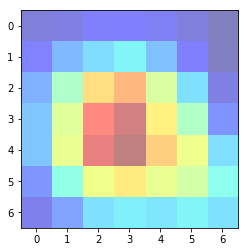

In [149]:
imshow(overlay[0], alpha=0.5, cmap='jet')

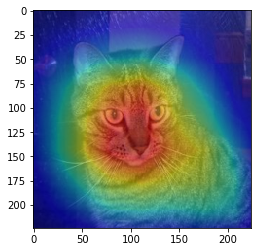

In [157]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[2:4]), alpha=0.5, cmap='jet')